# Anime Analysis by Ben Osborn and OsbornAI

## This project consists of the scraping and creation of a dataset containing information about all anime's listed on MyAnimeList. This data is analysed, and a model is created to predict whether an anime's rating will be above or below average

## Data source: https://myanimelist.net/

### Scraping and dataset creation

#### Parses through the labels and the lists from the soup elements

In [1]:
from bs4 import BeautifulSoup

def parseList(element):
    ret_list = [a.text for a in element.find_all('a')]
    
    return ", ".join(ret_list)

def parseLabel(element):
    string = element.text
    
    split_colens = string.split(':')
    removed_label = split_colens[1:]
    
    for i, label in enumerate(removed_label):
        removed_label[i] = label.replace('\n', '').strip()
    
    joined = " ".join(removed_label)
    
    return joined

#### These are the names of the raw initial columns in the dataframe

In [2]:
field_names = ['name_english', 'name_japanese', 'show_type', 'episodes', 'status', 'aired', 'broadcast_time', 'producers', 
               'licensors', 'studios', 'source', 'genres', 'episode_length', 'rating', 'score_and_scorers', 
               'members', 'favorites', 'description']

#### Scrapes the page from the show and returns a row of data for the dataframe

In [3]:
import requests

def createRow(url):
    ret_dict = {field_name: '' for field_name in field_names}

    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')

    side_panel = soup.find('td', class_='borderClass')
    side_panel_subdiv = side_panel.find('div')
    side_panel_divs = side_panel_subdiv.find_all('div')

    try:
        ret_dict['description'] = soup.find('p', itemprop='description').text

    except Exception as e:
        print(f"Encountered an error '{e}' for description at '{url}'.")

    for panel in side_panel_divs:
        try:
            split = str(panel.text.split(':')[0].strip())

            if split == "English":
                ret_dict['name_english'] = parseLabel(panel)

            if split == "Japanese":
                ret_dict['name_japanese'] = parseLabel(panel)

            if split == "Type":
                ret_dict['show_type'] = parseLabel(panel)

            if split == "Episodes":
                ret_dict['episodes'] = parseLabel(panel)

            if split == "Status":
                ret_dict['status'] = parseLabel(panel)

            if split == "Aired":
                ret_dict['aired'] = parseLabel(panel)

            if split == "Broadcast":
                ret_dict['broadcast_time'] = parseLabel(panel)

            if split == "Producers":
                ret_dict['producers'] = parseList(panel)

            if split == "Licensors":
                ret_dict['licensors'] = parseList(panel)

            if split == "Studios":
                ret_dict['studios'] = parseList(panel)

            if split == "Source":
                ret_dict['source'] = parseLabel(panel)

            if split == "Genres":
                ret_dict['genres'] = parseList(panel)

            if split == "Duration":
                ret_dict['episode_length'] = parseLabel(panel)

            if split == "Rating":
                ret_dict['rating'] = parseLabel(panel).split(' ')[0]

            if split == "Score":
                ret_dict['score_and_scorers'] = ", ".join([part.text for part in panel.find_all('span')][1:])

            if split == "Members":
                ret_dict['members'] = "".join(parseLabel(panel).split(','))

            if split == "Favorites":
                ret_dict['favorites'] = "".join(parseLabel(panel).split(','))

        except Exception as e:
            print(f"Encountered an error '{e}' at '{url}'.")
            
    return ret_dict
    
# createRow("https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood")

#### Go through the amount of pages specified then scrape the information for each show, then store them to a CSV file

In [4]:
import os
from csv import DictWriter
import time

def genDataset(end_page, csv_dir, csv_filename, start_page=0):
    link = 'Unknown'
            
    for i in range(start_page, end_page):
        
        print(f"Scraping page {i}...")

        csv_path = os.path.join(csv_dir, f'{csv_filename}-{i}.csv')

        with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            writer = DictWriter(csvfile, fieldnames=field_names)
            
            writer.writeheader()

            url_page = f"https://myanimelist.net/topanime.php?limit={i*50}"
            req_list = requests.get(url_page)
            soup_list = BeautifulSoup(req_list.content, 'html.parser')
            shows = soup_list.find_all('tr', class_='ranking-list')

            for show in shows:
                try:
                    link = show.find('a').get('href')
                    data_row = createRow(link)
                    writer.writerow(data_row)

                    time.sleep(2) # These are required to stop the website from blocking us

                except Exception as e:
                    print(f"Encountered error '{e}' at '{link}'.")
                    
                    time.sleep(2)
    
    print("Dataset creation complete!")
    
csv_dir = os.path.join(os.getcwd(), 'csv')
# genDataset(300, csv_dir, 'mal-data-20-11-2020', start_page=0)

### Data handling and cleaning

#### Concatenate CSV files and put them into a data frame

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

csv_path = os.path.join(os.getcwd(), 'csv')

dfs = []
for csv in os.listdir(csv_path):
    dfs.append(pd.read_csv(os.path.join(csv_path, csv), index_col=0))

df = pd.concat(dfs)

#### Type conversion and data cleanup

In [6]:
df = df[df['episodes'] != 'Unknown']
df['episodes'] = df['episodes'].astype(int)

df['favorites'] = df['favorites'].astype(int)

df['members'] = df['members'].astype(int)

df = df.dropna(how='all')

In [7]:
def parseScoreAndScorer(score_and_scorers_raw, position):
    try:
        stripped = score_and_scorers_raw.split(', ')[position].strip()
        numerical_version = float(stripped)
        
        return numerical_version
    
    except:
        return pd.NaT

def scoreParsedDf(df):
    parsed_score_df = df.copy()

    parsed_score_df['score'] = parsed_score_df['score_and_scorers'].apply(lambda s: parseScoreAndScorer(s, 0))
    parsed_score_df = parsed_score_df[parsed_score_df['score'].notna()]
    parsed_score_df['score'] = parsed_score_df['score'].astype(float)

    parsed_score_df['scorers'] = parsed_score_df['score_and_scorers'].apply(lambda s: parseScoreAndScorer(s, 1))
    parsed_score_df = parsed_score_df[parsed_score_df['scorers'].notna()]
    parsed_score_df['scorers'] = parsed_score_df['scorers'].astype(int)

    parsed_score_df = parsed_score_df.drop('score_and_scorers', axis=1)
    
    return parsed_score_df

#### Time data parsing

In [8]:
def broadcastParse(broadcast_raw):
    try:
        broadcast_split = [bc_time.strip() for bc_time in broadcast_raw.split(' at ')]
        if (len(broadcast_split) == 1) or ('Unknown' in broadcast_split):
            return pd.NaT
        broadcast_split[0] = broadcast_split[0][:-1]
        broadcast_split[1] = broadcast_split[1][:5]
        broadcast_string = " ".join(broadcast_split)

        return broadcast_string
    
    except:
        return pd.NaT

def broadcastParsedDf(df):
    parsed_broadcast_df = df.copy()

    parsed_broadcast_df['broadcast_time'] = parsed_broadcast_df['broadcast_time'].apply(broadcastParse)
    parsed_broadcast_df = parsed_broadcast_df[parsed_broadcast_df['broadcast_time'].notna()]
    parsed_broadcast_df['broadcast_time'] = pd.to_datetime(parsed_broadcast_df['broadcast_time'], format='%A %H %M')
    
    return parsed_broadcast_df

In [9]:
def timeParse(time_raw):
    try:
        time_split = time_raw.split(' ')
        if time_split[1] == 'min.':
            return int(time_split[0])
        elif time_split[1] == 'hr.':
            if time_split[3] == 'min.':
                return int(time_split[0]) * 60 + int(time_split[2])
            else:
                return int(time_split[0]) * 60 # This will make sure that if there is only an hour it will not break

        else:
            return pd.NaT
    
    except:
        return pd.NaT
    
def timeParsedDf(df):
    ep_length_parsed_df = df.copy()    

    ep_length_parsed_df['episode_length'] = ep_length_parsed_df['episode_length'].apply(timeParse)
    ep_length_parsed_df = ep_length_parsed_df[ep_length_parsed_df['episode_length'].notna()]
    
    return ep_length_parsed_df

In [10]:
def parseAired(aired_raw, position):
    try:
        aired_split = aired_raw.split(' to ')
        aired_parsed = " ".join(aired_split[position].strip().split(", "))
        aired_formatted = str(time.strftime('%d %m %Y', time.strptime(aired_parsed, '%b %d %Y')))
        
        return aired_formatted
    
    except:
        return pd.NaT

def airedParsedDf(df):
    aired_parsed_df = df.copy()

    aired_parsed_df['aired_start'] = aired_parsed_df['aired'].apply(lambda s: parseAired(s, 0))
    aired_parsed_df = aired_parsed_df[aired_parsed_df['aired_start'].notna()]
    aired_parsed_df['aired_start'] = pd.to_datetime(aired_parsed_df['aired_start'], format='%d %m %Y')

    aired_parsed_df['aired_end'] = aired_parsed_df['aired'].apply(lambda s: parseAired(s, 1))
    aired_parsed_df = aired_parsed_df[aired_parsed_df['aired_end'].notna()]
    aired_parsed_df['aired_end'] = pd.to_datetime(aired_parsed_df['aired_end'], format='%d %m %Y')

    aired_parsed_df = aired_parsed_df.drop('aired', axis=1)
    
    return aired_parsed_df

### Data analysis

#### Question 1: What is the highest rated show in consideration with the amount of users?

In [11]:
# To solve this we say the rating is the probability of an anime being good, then we take the Z-scores 
# and we look at the highest Z-score which means it will be the anime that exceeds the average 
# chance of it being good based on its members

parsed_score_df = scoreParsedDf(df)
parsed_score_df = parsed_score_df[parsed_score_df.index.notna()]

good_probability = parsed_score_df['score'].mean() / 10
probabilities = parsed_score_df['score'] / 10
stds = (good_probability * (1 - good_probability) / parsed_score_df['scorers']) ** 0.5
weighted_rating = (probabilities - good_probability) / stds

weighted_sorted = weighted_rating.sort_values(ascending=False)
print(f"The anime with the highest score considering it's watchers is {weighted_sorted.index[0]}\n")
print(f"Top anime with the highest rating's considering it's watchers: \n{weighted_sorted}")

The anime with the highest score considering it's watchers is Fullmetal Alchemist Brotherhood

Top anime with the highest rating's considering it's watchers: 
name_english
Fullmetal Alchemist Brotherhood    586.141672
Death Note                         503.985363
Your Name.                         489.165620
Steins;Gate                        476.268204
Hunter x Hunter                    459.687057
                                      ...    
King's Game                       -103.693556
Diabolik Lovers                   -104.657199
School Days                       -118.719425
Mars of Destruction               -179.943741
Pupa                              -190.513413
Length: 5269, dtype: float64


##### The best anime with the highest score based on its users is Fullmetal Alchemist as it has the highest Z-score above the mean rating based on it's users compared to the others

#### Question 2: What is the most popular genre on average?

Text(0.5, 1.0, 'Average members for each genre')

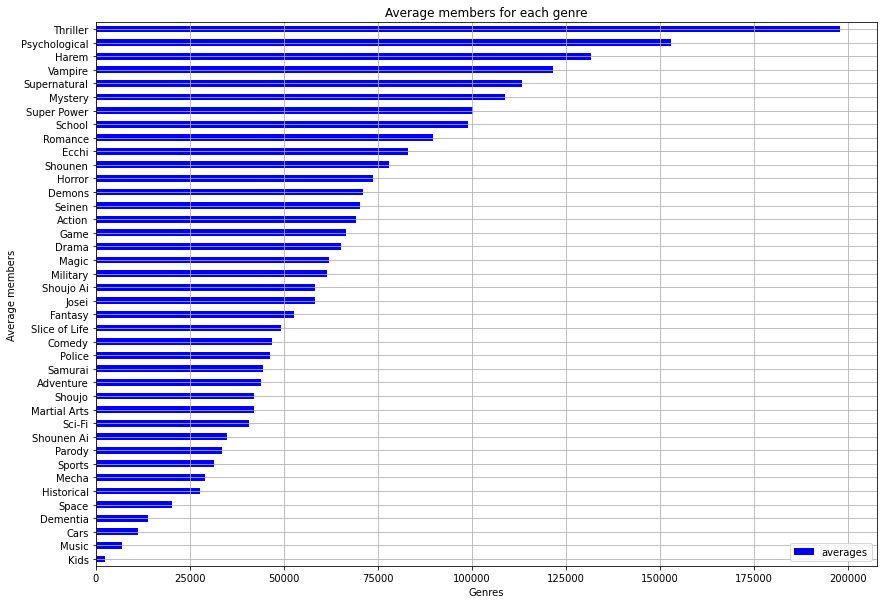

In [12]:
# To do this we are going to have to gather all of the different genre's and then make a new dataframe with these genres
# and then look at the one with the highest memberbase

genre_df = df[df['genres'].notna()]
genre_df = genre_df[genre_df['genres'] != 'add some']

genres = []
def makeDataList(array_string, data_list):
    split_string = array_string.split(", ")
    for item in split_string:
        if item not in data_list:
            data_list.append(item)

genre_df['genres'].apply(lambda s: makeDataList(s, genres))

genre_average_df = pd.DataFrame()

averages = []
for genre in genres:
    dummy_df = genre_df[genre_df['genres'].str.contains(genre)]
    average_members = dummy_df['members'].mean()
    averages.append(average_members)

genre_average_df['genres'] = genres
genre_average_df['averages'] = averages

genre_average_df.sort_values(by='averages').plot.barh(x='genres', y='averages', grid=True, color='blue')
plt.xlabel('Genres')
plt.ylabel('Average members')
plt.title('Average members for each genre')

##### The most popular genre on average was 'Thriller', followed by 'Pyschological'. The least popular genre was 'Kids'.

#### Question 3: What is the best month of the to launch a show for the most viewers?

Text(0.5, 1.0, 'Average members for the month the show was aired')

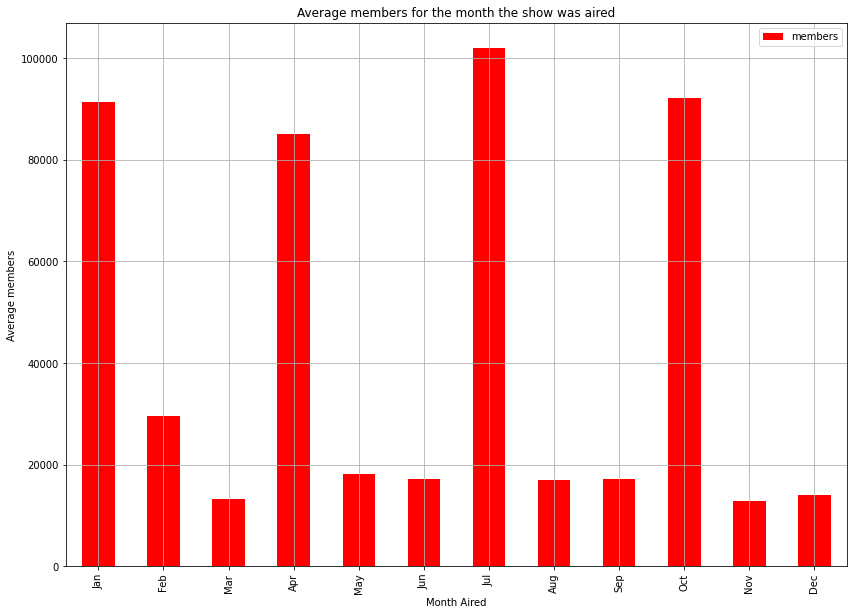

In [13]:
# Make seperate columns of the hour and then group by the hour under the average

viewers_df = airedParsedDf(df)
viewers_df['aired_month'] = viewers_df['aired_start'].dt.month # Sort this dataframe by the column

viewers_df = viewers_df.groupby('aired_month').mean()
viewers_df.index = pd.to_datetime(viewers_df.index, format='%m').month_name().str[:3]
viewers_df = viewers_df.drop(['episodes', 'favorites'], axis=1)

viewers_df.plot.bar(grid=True, color='red')
plt.xlabel('Month Aired')
plt.ylabel('Average members')
plt.title('Average members for the month the show was aired')

##### The most successful anime's with the largest amount of watchers on average were aired during January, April, July and October. It is hypothesized that this is because the times stated are around the Japanese school holidays, leading to an increase in free time for kids and teenagers to watch anime.

#### Question 4: What was the best time to broadcast

Text(0.5, 1.0, "Average members of anime and the time's they were broadcasted")

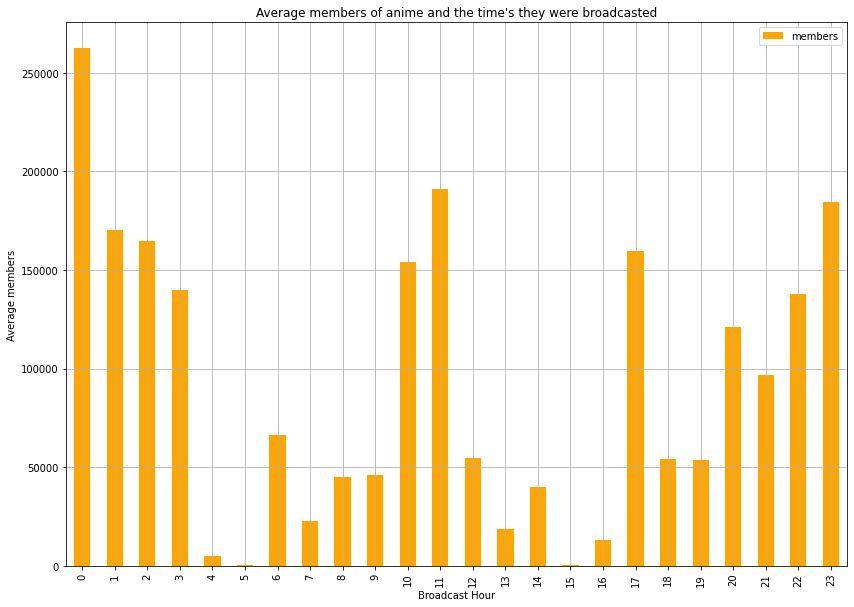

In [14]:
# We want to make a seperate column for the broadcast time in terms of its hour during the day

bc_df = broadcastParsedDf(df)
bc_df['broadcast_hour'] = bc_df['broadcast_time'].dt.hour
bc_df = bc_df.groupby('broadcast_hour').mean()
bc_df = bc_df.drop(['episodes', 'favorites'], axis=1)

bc_df.plot.bar(grid=True, color='orange')
plt.xlabel('Broadcast Hour')
plt.ylabel('Average members')
plt.title('Average members of anime and the time\'s they were broadcasted')

##### The shows with the highest amount of watchers were released around 10:00AM, or around 00:00PM. The 10:00AM is hypothesized to be because kids and teenagers are getting out of bed around this time and watch their shows first thing in the morning, and the late night popularity is hypothesized to be because of people watching shows before they go to sleep as relaxation. Therefore these are the best times to broadcast a show to maximize its popularity.

#### Question 5: What studios have the best ratings with consideration for the amount of scorers?

In [15]:
# Use the standard deviation except this time use the data from the other Z-Scores to find where the studios are the best
# Using the same parsing function defined in the popular genre

studio_df = scoreParsedDf(df)
studio_df = studio_df[studio_df['studios'].notna()]
studio_df = studio_df[studio_df['studios'] != 'add some']

studios = []
studio_df['studios'].apply(lambda s: makeDataList(s, studios))

studio_average_df = pd.DataFrame()

average_scores = []
average_scorers = []
for studio in studios:
    dummy_df = studio_df[studio_df['studios'].str.contains(studio)]
    avg_score = dummy_df['score'].mean() # This will be the average score for the studio
    avg_scorers = dummy_df['scorers'].mean() # This will be the average amount of scorers for the studio # WAIT IM CHANGING THIS -----------
    average_scores.append(avg_score)
    average_scorers.append(avg_scorers)

studio_average_df['studios'] = studios
studio_average_df['average_scores'] = average_scores
studio_average_df['average_scorers'] = average_scorers

good_probability = studio_average_df['average_scores'].mean() / 10
probabilities = studio_average_df['average_scores'] / 10
stds = (good_probability * (1 - good_probability) / studio_average_df['average_scorers']) ** 0.5
studio_average_df['weighted_rating'] = (probabilities - good_probability) / stds

best_scored_studios = studio_average_df.sort_values(ascending=False, by='weighted_rating').iloc[:, 0]
print(f"The studio with the best average ratings based on the amount of members is {best_scored_studios.iloc[0]}.\n")
print(f"Studios rated from best ratings to worst ratings:\n{best_scored_studios}")

The studio with the best average ratings based on the amount of members is Studio Chizu.

Studios rated from best ratings to worst ratings:
22        Studio Chizu
34            Egg Firm
457       Animation Do
486           Kadokawa
7           Wit Studio
            ...       
478        Studio elle
479       l-a-unch・BOX
482     Studio! Cucuri
465    Magia Doraglier
461          W+K Tokyo
Name: studios, Length: 550, dtype: object


##### The studio with the highest average score across all of the scorers is 'Studio Chizu', followed by 'Egg Firm'. The studio with the lowest score across scorers is 'W+K Tokyo'.

#### Question 6: What licensors have the best ratings with consideration for the amount of users?

The licensor with the best ratings for it's amount of watchers is Walt Disney Studios



Text(0.5, 1.0, 'Standard deviations above the mean score for licensors')

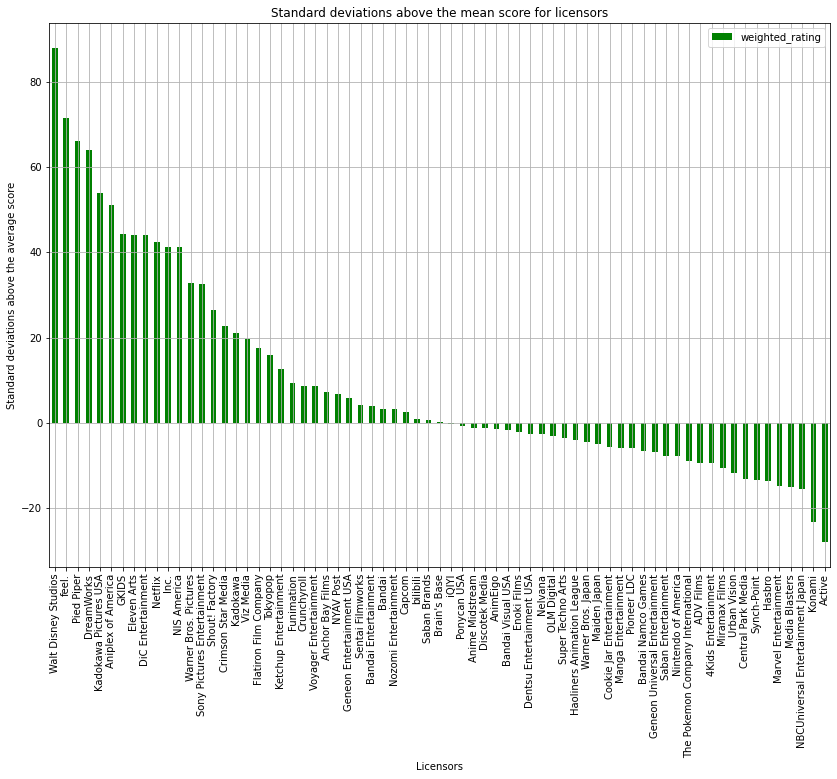

In [16]:
# Similar question to question 5, so we will answer it in a similar way

licensor_df = scoreParsedDf(df)
licensor_df = licensor_df[licensor_df['licensors'].notna()]
licensor_df = licensor_df[licensor_df['licensors'] != 'add some']

licensors = []
licensor_df['licensors'].apply(lambda s: makeDataList(s, licensors))

licensor_average_df = pd.DataFrame()

average_scores = []
average_scorers = []
for licensor in licensors:
    dummy_df = licensor_df[licensor_df['licensors'].str.contains(licensor)]
    avg_score = dummy_df['score'].mean()
    avg_scorers = dummy_df['scorers'].mean()
    average_scores.append(avg_score)
    average_scorers.append(avg_scorers)

licensor_average_df['licensors'] = licensors
licensor_average_df['average_scores'] = average_scores
licensor_average_df['average_scorers'] = average_scorers

good_probability = licensor_average_df['average_scores'].mean() / 10
probabilities = licensor_average_df['average_scores'] / 10
stds = (good_probability * (1 - good_probability) / licensor_average_df['average_scorers']) ** 0.5
licensor_average_df['weighted_rating'] = (probabilities - good_probability) / stds
licensor_average_df = licensor_average_df.sort_values(by='weighted_rating', ascending=False)

print(f"The licensor with the best ratings for it's amount of watchers is {licensor_average_df.iloc[0, 0]}\n")
licensor_average_df.plot.bar(x='licensors', y='weighted_rating', grid=True, color='green')
plt.xlabel('Licensors')
plt.ylabel('Standard deviations above the average score')
plt.title('Standard deviations above the mean score for licensors')

##### The licensor with the most ratings on average across average scorers is 'Walt Disney Studios', followed by 'feel.'. The licensor with the lowest average score across average scorers is 'Active'.

### Data preprocessing for model

#### This model will predict if a show is above or below average using it's genres, licensors, producers, studios and its description.

#### Create and shuffle data

In [17]:
import random
import string

def preprocessWord(word):
    new_word = word.lower()
    word_chars = [char for char in new_word if char in string.ascii_lowercase]
    
    return "".join(word_chars)
        
def preprocessText(description, studios, licensors, producers, genres):
    total = []
    
    studios_split = studios.split(',')
    for studio in studios_split:
        total.append(preprocessWord(studio))
        
    licensors_split = licensors.split(',')
    for licensor in licensors_split:
        total.append(preprocessWord(licensor))
    
    producers_split = producers.split(',')
    for producer in producers_split:
        total.append(preprocessWord(producer))
    
    genres_split = genres.split(',')
    for genre in genres_split:
        total.append(preprocessWord(genre))

    description_split = description.split(' ')
    for word in description_split:
        total.append(preprocessWord(word))
        
    return " ".join(total)

def shuffleData(inputs, labels):
    data_set = []
    for i in range(len(inputs)):
        data_set.append((inputs[i], labels[i]))
    random.shuffle(data_set)
    
    shuffled_inputs = [tup[0] for tup in data_set]
    shuffled_labels = [tup[1] for tup in data_set]
    
    return shuffled_inputs, shuffled_labels

def createModelData(df):
    row_num = len(df.index)
    text_data = []
    score_data = []
    
    for i in range(row_num):
        row = df.iloc[i]
        description = row[15]
        studios = row[8]
        licensors = row[7]
        producers = row[6]
        genres = row[10]
        
        row_text = preprocessText(description, studios, licensors, producers, genres)
        score = row[16] / 10
        
        text_data.append(row_text)
        score_data.append(score)
        
    return shuffleData(text_data, score_data)

word_df = scoreParsedDf(df)
word_df = word_df[word_df['description'].notna()]
word_df = word_df[word_df['studios'].notna()]
word_df = word_df[word_df['licensors'].notna()]
word_df = word_df[word_df['producers'].notna()]
word_df = word_df[word_df['genres'].notna()]

text_data, score_data = createModelData(word_df)

#### Make word map and convert descriptions to number format

In [18]:
from collections import Counter

words = " ".join([text for text in text_data]).split(' ')
counter = Counter(words)
most_common = counter.most_common()

word_map = {word: i+1 for i, (word, count) in enumerate(most_common)}

def sentenceToId(sentence, word_map):
    sentence_split = sentence.split(' ') # Here we assume that the sentence has been parsed properly
    encoded_sentence = [word_map[word] for word in sentence_split] # This means this is probably returning a none value
    
    return encoded_sentence

encoded_text = [sentenceToId(desc, word_map) for desc in text_data]

#### Remove outliers from the data

count    10694.000000
mean        83.155040
std         61.805161
min          6.000000
25%         28.000000
50%         69.000000
75%        126.000000
max        470.000000
dtype: float64


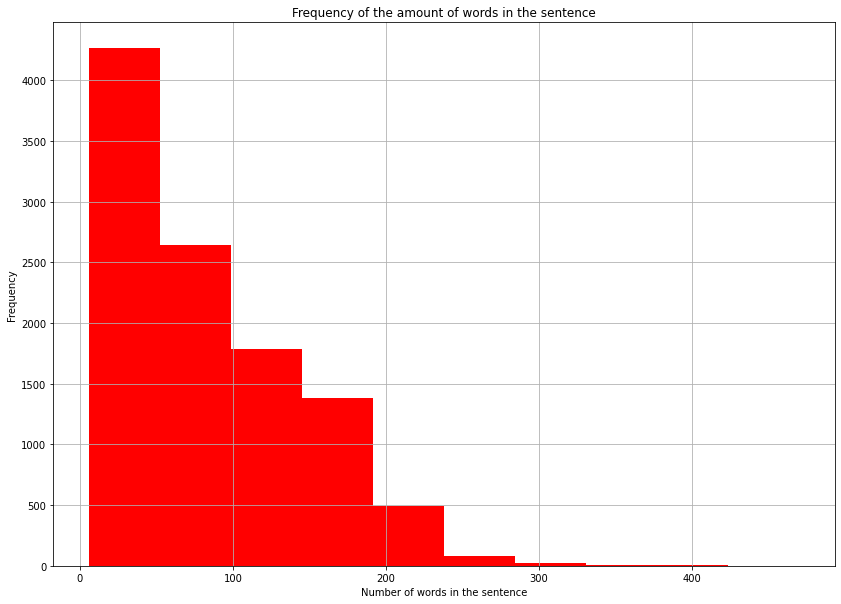

In [19]:
encoded_lens = [len(text) for text in encoded_text]
series = pd.Series(encoded_lens)

print(series.describe())
series.hist(color='red')
plt.xlabel('Number of words in the sentence')
plt.ylabel('Frequency')
plt.title('Frequency of the amount of words in the sentence')

mean_raw = series.mean()
std_raw = series.std()

count    10640.000000
mean        81.954887
std         59.519943
min          6.000000
25%         28.000000
50%         69.000000
75%        125.000000
max        268.000000
dtype: float64


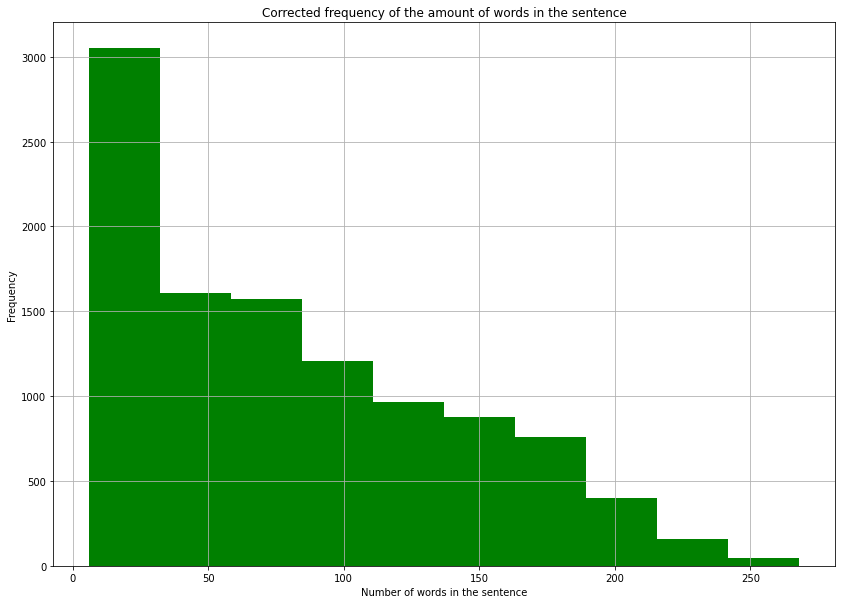

In [20]:
import numpy as np

encoded_text_cleaned = []
score_data_cleaned = []
for i, length in enumerate(encoded_lens):
    z_score = (length - mean_raw) / std_raw
    if (z_score > -3) and (z_score < 3):
        encoded_text_cleaned.append(encoded_text[i])
        score_data_cleaned.append(score_data[i])
      
encoded_lens_new = [len(text) for text in encoded_text_cleaned]
new_series = pd.Series(encoded_lens_new)

print(new_series.describe())
new_series.hist(color='green')
plt.xlabel('Number of words in the sentence')
plt.ylabel('Frequency')
plt.title('Corrected frequency of the amount of words in the sentence')

mean_text_length = int(np.round(new_series.mean()))

#### Padding and truncation of words for embedding layer

In [21]:
def correctSize(vector, vector_size):
    vec_len = len(vector)
    
    if vec_len == vector_size:
        return vector
    
    elif vec_len < vector_size:
        ret_vector = vector.copy()
        for _ in range(vector_size - vec_len):
            ret_vector.append(0)
        return ret_vector
    
    elif vec_len > vector_size:
        return vector[:vector_size]
    
padded_text = [correctSize(text, mean_text_length) for text in encoded_text_cleaned]

#### Determine if a show is above or below average

In [22]:
avg_score = np.mean(score_data)
binary_score_data = [1 if score > avg_score else 0 for score in score_data]

#### Split data into sets for the network

In [23]:
good_len = len(padded_text) - len(padded_text) % 10

fixed_padded_text = padded_text[:good_len]
fixed_score = binary_score_data[:good_len]

train_len = int(0.8 * good_len)
val_len = int(0.1 * good_len)
test_len = int(0.1 * good_len)

train_text = np.array(fixed_padded_text[:train_len])
train_labels = np.array(fixed_score[:train_len])
train_data = (train_text, train_labels)

remaining_text = fixed_padded_text[train_len:]
remaining_labels = fixed_score[train_len:]

val_text = np.array(remaining_text[:val_len])
val_labels = np.array(remaining_labels[:val_len])
val_data = (val_text, val_labels)

test_text = np.array(remaining_text[test_len:])
test_labels = np.array(remaining_labels[test_len:])
test_data = (test_text, test_labels)

print(f"{train_len} training samples | {val_len} validation samples | {test_len} test samples | {good_len} total samples")

8512 training samples | 1064 validation samples | 1064 test samples | 10640 total samples


### Model building and testing

#### Model creation, training, loading and saving

In [24]:
import tensorflow as tf
import pickle

class Model:
    def __init__(self, model_dir):
        self.__model = None
        self.__history = None
        self.__model_dir = model_dir
        
    def create(self, word_map, mean_text_length):
        self.__model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=len(word_map) + 1, output_dim=mean_text_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.4)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.__model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1), metrics=['accuracy'])

    def train(self, train_data, epochs, batch_size, validation_data):
        self.__history = self.__model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=validation_data).history

    def evaluate(self, test_data, epochs):
        evaluation = self.__model.evaluate(test_data[0], test_data[1], epochs)
        eval_dict = {'loss': evaluation[0], 'accuracy': evaluation[1]}
        print(f"Loss on test data: {eval_dict['loss']} | Accuracy on test data: {eval_dict['accuracy']}\n")
        
        return eval_dict
        
    def save(self):
        model_as_json = self.__model.to_json()
        with open(os.path.join(self.__model_dir, 'model.json'), 'w') as json_file:
            json_file.write(model_as_json)
        self.__model.save_weights(os.path.join(self.__model_dir, 'model.h5'))

        with open(os.path.join(self.__model_dir, 'history.p'), 'wb') as pickle_file:
            pickle.dump(self.__history.history, pickle_file)

        print(f"Saved model to {self.__model_dir}.")

    def load(self):
        with open(os.path.join(self.__model_dir, 'model.json'), 'r') as json_file:
            model_as_json = json_file.read()
        self.__model = tf.keras.models.model_from_json(model_as_json)
        self.__model.load_weights(os.path.join(self.__model_dir, 'model.h5'))
        self.__model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1), metrics=['accuracy'])

        with open(os.path.join(self.__model_dir, 'history.p'), 'rb') as pickle_file:
            self.__history = pickle.load(pickle_file)
            
    def __call__(self):
        return self.getModel()
            
    def getModel(self):
        return self.__model
    
    def getHistory(self):
        return self.__history

model_path = os.path.join(os.getcwd(), 'model')
model = Model(model_path)
# model.create(word_map, mean_text_length)
model.load()

In [25]:
# model.train(train_data, 30, 64, val_data)
# model.save()

### Analysis and testing of the model

#### Analysis of the model during training

In [26]:
evaluation = model.evaluate(test_data, 64)
history = model.getHistory()

plt.plot(history['loss'], label='train loss')
plt.plot(history['accuracy'], label='train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Amount')
plt.title('Loss and accuracy for epochs on train data')
plt.legend()
plt.show()

plt.plot(history['val_loss'], label='validation loss')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Amount')
plt.legend()
plt.title('Loss and accuracy for epochs on validation data')

UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_1/bidirectional_1/forward_lstm_1/PartitionedCall]] [Op:__inference_test_function_3261]

Function call stack:
test_function -> test_function -> test_function


##### As demonstrated by the charts above, the model becomes good at fitting the training data, but the validation data's accuracy stays the same around 0.5 for every epoch, and the loss follows an upwards trend every epoch. This demonstrates that there is very little correlation between the description, studios, licensors, genres and producers of a show and the rating that it will get. This could be because viewers like unique shows that provide a unique story, and therefore the descriptions will all vary between what people like, and thus there is no 'magic' description which results in a good show.

#### Model testing

In [ ]:
import random

def predictAnime(model, description, studios, licensors, producers, genres, word_map, correct_text_length):
    listToCom = lambda list_raw: ",".join(list_raw)
    
    studios_as_commas = listToCom(studios)
    licensors_as_commas = listToCom(licensors)
    producers_as_commas = listToCom(producers)
    genres_as_commas = listToCom(genres)

    row_text = preprocessText(description, studios_as_commas, licensors_as_commas, producers_as_commas, genres_as_commas)
    
    row_as_ids = sentenceToId(row_text, word_map)
    row_corrected = np.array([correctSize(row_as_ids, correct_text_length)])
    prediction = model().predict(row_corrected)
    
    return np.round(prediction.item(), 3)

print("Sample evaluations for 5 values from the test set:")
sample = test_data
for _ in range(5):
    random_int = random.randint(0, test_len-1)
    test_txt = np.array([test_data[0][random_int]])
    test_lbl = test_data[1][random_int]
    prediction = model().predict(test_txt)

    print(f"Prediction: {np.round(prediction.item(), 3)} | Actual {test_lbl}")
    
# ------------ Test sample ------------
    
sample_description = "\"In order for something to be obtained, something of equal value must be lost.\" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called \"automail\" and become a state alchemist, the Fullmetal Alchemist.Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
sample_studios = ['Bones']
sample_licensors = ['Funimation', 'Aniplex of America']
sample_producers = ['Aniplex', 'Square Enix', 'Mainichi Broadcasting System', 'Studio Moriken']
sample_genres = ['Action', 'Military', 'Adventure', 'Comedy', 'Drama', 'Magic', 'Fantasy', 'Shounen']

sample_prediction = predictAnime(model, sample_description, sample_studios, sample_licensors, sample_producers, sample_genres, word_map, mean_text_length)
print("\nSample prediction from a custom anime:")
print(sample_prediction)